In [23]:
import numpy as np
import matplotlib.pyplot as plt
import Load_Data
import os
import time
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
import keras.callbacks
%matplotlib inline

In [2]:
def plot_images(images, true_labels, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.subplots_adjust(hspace = 0.3)
    idx = np.random.choice(np.arange(len(images)), 16, replace=False)
    random_images = images[idx]
    random_labels = true_labels[idx]
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(random_images[i], interpolation='spline16')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_xlabel('True : {}'.format(labels[random_labels[i]].decode('utf-8')))

# Load Data

In [3]:
xtrain, ytrain = Load_Data.load_train_data()
xtest, ytest = Load_Data.load_test_data()
labels = Load_Data.get_labels()

In [4]:
train_data = {'xtrain':xtrain, 'ytrain':ytrain}
test_data = {'xtest':xtest, 'ytest':ytest}

# Visualization

No of Train Images: 50000
No of Test Images: 10000
Shape of an image: 32 32 3
No of classes: 10
-----------------------------------------------------------
Example Images: 


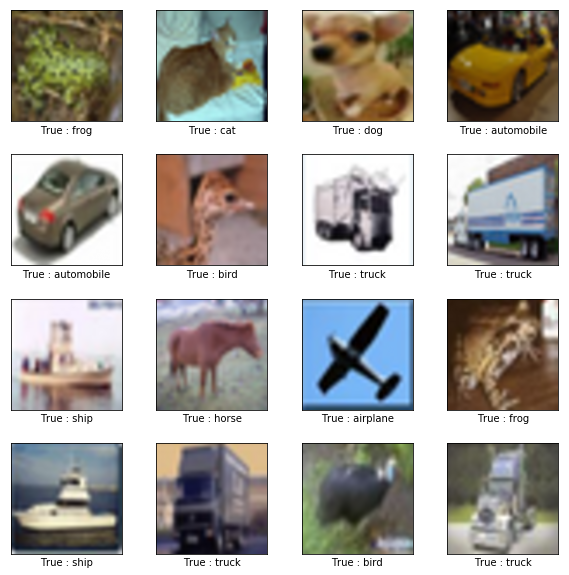

In [5]:
length, breadth, depth = xtrain.shape[1:]
no_of_train_images = xtrain.shape[0]
no_of_test_images = xtest.shape[0]
no_of_classes = len(labels)
print("No of Train Images: {}".format(no_of_train_images))
print("No of Test Images: {}".format(no_of_test_images))
print("Shape of an image: {} {} {}".format(length, breadth, depth))
print("No of classes: {}".format(no_of_classes))
print("-----------------------------------------------------------")
print("Example Images: ")
plot_images(xtrain, ytrain, labels)

In [6]:
save_dir = 'saved_model/'
save_path = os.path.join(save_dir, 'cifar10_cnn.h5')

# Create Network

In [25]:
def create_network(xtrain, show_summary):
    print("Creating CNN Network")
    start = time.time()
    model = Sequential()

    conv1 = model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape = (length, breadth, depth),\
                             padding='same' ,activation='relu'))
    max1 = model.add(MaxPooling2D(pool_size=(2, 2)))
    conv2 = model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same' ,activation='relu'))
    max2 = model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    conv3 = model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same' ,activation='relu'))
    max3 = model.add(MaxPooling2D(pool_size=(2, 2)))
    conv4 = model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same' ,activation='relu'))
    max4 = model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    conv5 = model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same' ,activation='relu'))
    max5 = model.add(MaxPooling2D(pool_size=(2, 2)))
    conv6 = model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same' ,activation='relu'))
#     max6 = model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    dense1 = model.add(Dense(units=1024, activation='relu'))
    model.add(Dropout(0.5))
    dense2 = model.add(Dense(units=512, activation='relu'))
    dense1 = model.add(Dense(units=no_of_classes, activation='softmax'))
    print("Model Created in {}\n".format(time.time()-start))
    if show_summary:
        print("Model Summary")
        model.summary()
    return model

In [46]:
def get_categorical(ytrain, ytest):
    return (keras.utils.to_categorical(ytrain, num_classes=no_of_classes),\
            keras.utils.to_categorical(ytest, num_classes=no_of_classes))

def train_network(train_data, test_data, epochs, verbose, show_summary):
    model = create_network(train_data['xtrain'], show_summary=show_summary)
    print("\n--------------------------------------------")
    print("\nTraining the Network")
    start=time.time()
    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.05, patience=15,\
                                                            verbose=1, mode='auto')
    
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    ytrain, ytest = get_categorical(train_data['ytrain'], test_data['ytest'])
    model.fit(train_data['xtrain'], ytrain, epochs=epochs, verbose=verbose,\
              batch_size=128, callbacks=[early_stopping_callback], validation_data=(test_data['xtest'], ytest), shuffle=True)
    
    print("Model trained in {}\n".format(time.time()-start))
    return model

In [40]:
def is_model_saved():
    print("Trying to restore saved model")
    return os.path.exists(save_path)

In [41]:
def cnn_model(train_data, test_data, epochs, verbose=1, show_summary=True):
    if is_model_saved():
        print("Model Restored\n\n")
        model = load_model(save_path)
        print("Model Summary")
        if show_summary:
            model.summary()
    else:
        print("Unable to restore model\n\n")
        print("--------------------------------------------\n")
        print("Creating and training new CNN Model\n")
        model = train_network(train_data, test_data, epochs, verbose, show_summary)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        model.save(save_path)
        return model

In [42]:
epochs = 50
model=cnn_model(train_data, test_data, epochs=epochs)

Trying to restore saved model
Unable to restore model


--------------------------------------------

Creating and training new CNN Model

Creating CNN Network
Model Created in 0.2045743465423584

Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 128)         0         
_______________________________________________________________

In [44]:
model.evaluate(test_data['xtest'], keras.utils.to_categorical(test_data['ytest'],10), batch_size=64)

 9920/10000 [============================>.] - ETA: 0s

[0.6602857841491699, 0.7784]

In [45]:
model.metrics_names

['loss', 'acc']

In [48]:
epochs = 50
model=cnn_model(train_data, test_data, epochs=epochs)

Trying to restore saved model
Unable to restore model


--------------------------------------------

Creating and training new CNN Model

Creating CNN Network
Model Created in 0.2075514793395996

Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 8, 8, 128)         0         
_______________________________________________________________

50000/50000 [==============================] - 15s - loss: 0.8107 - acc: 0.7099 - val_loss: 0.7698 - val_acc: 0.7305
Epoch 42/50
50000/50000 [==============================] - 15s - loss: 0.8015 - acc: 0.7152 - val_loss: 0.8000 - val_acc: 0.7184
Epoch 43/50
50000/50000 [==============================] - 15s - loss: 0.7922 - acc: 0.7159 - val_loss: 0.7661 - val_acc: 0.7314
Epoch 44/50
50000/50000 [==============================] - 15s - loss: 0.7810 - acc: 0.7213 - val_loss: 0.7773 - val_acc: 0.7276
Epoch 45/50
50000/50000 [==============================] - 15s - loss: 0.7750 - acc: 0.7247 - val_loss: 0.7668 - val_acc: 0.7316
Epoch 46/50
50000/50000 [==============================] - 15s - loss: 0.7647 - acc: 0.7283 - val_loss: 0.7875 - val_acc: 0.7203
Epoch 47/50
50000/50000 [==============================] - 15s - loss: 0.7554 - acc: 0.7319 - val_loss: 0.7802 - val_acc: 0.7242
Epoch 48/50
50000/50000 [==============================] - 15s - loss: 0.7471 - acc: 0.7339 - val_loss: 0.735

In [49]:
model.evaluate(test_data['xtest'], keras.utils.to_categorical(test_data['ytest'],10), batch_size=64)

 9920/10000 [============================>.] - ETA: 0s

[0.7389094184398651, 0.745]